# MSc Project ( 1.2 )

- Surya L Ramesh (0206793)

 

##  Iteration 1 - LinearSVC


In [ ]:
''' 
- Loads,Cleans the SNLI Datset. 
- Pipeline created for pre-processing. 
- LinearSVC trained on training set. 
- Hyperparameter tuning done using Validation Set 
- Tuned model is saved
- Prediction is done on select sentences '''

### Import Libraries 

In [77]:
import pandas as pd
import numpy as np

import re

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string


import joblib
import os
import fnmatch 
from termcolor import colored
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
import warnings
import time 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle


### Functions 

The code for the metadata extraction and pipieline is adapted from https://medium.com/@armandj.olivares/a-basic-nlp-tutorial-for-news-multiclass-categorization-82afa6d46aa5

In [2]:
''' function to load data and tidy it - pass the dataframe, keep only wanted columns, 
remove'-' rows from gold_label, remove rows with na , rename columns'''

def data_load_tidy(dataframe,isTest): 
    
    dataframe = dataframe[['sentence1','sentence2','gold_label']]    
    dataframe = dataframe[dataframe['gold_label'] != '-' ]
    dataframe1= dataframe.dropna(axis=0, inplace=False) 
    data_tidy = dataframe1.rename(columns= {'sentence1':'premise', 'sentence2':'hypothesis','gold_label':'target'}, inplace=False)
    
    print(colored('\n  data is tidied ....','green')) 
    return data_tidy

# isTest is not needed anymore- can be removed- kept for experimentation

In [35]:
''' function to get length of text for metadata'''
def len_text(text):
  if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
  else:
         return 0

In [36]:
''' function to  clean text using regex, lower the case  and lemmatize words'''
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text)
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) ]
  clean_text2 = [word for word in clean_text ]
  
  return " ".join(clean_text2)

In [37]:
warnings.filterwarnings('ignore')

In [38]:
def plot_confusion_matrix_custom(cm, classes, title='Confusion matrix - Linear SVC', cmap=plt.cm.Blues):
 
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False) 
   
    plt.show()

In [39]:


''' function written to view confusion matrix in colour  and print classification report'''

def visualize_confusion_matrix(y_pred_argmax, y_true):

    classes = ['entailment','contradiction','neutral']
    cm = confusion_matrix(y_true, y_pred_argmax)
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true,target_names=classes))

    plot_confusion_matrix_custom(cm,classes)


In [52]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class Textmetadata(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{ 'len': row['len']} for _, row in data.iterrows()]

In [53]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('premise', Pipeline([
                ('selector', ItemSelector(key='premise')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)), #No stopwords are used
            ])),
            ('hypothesis', Pipeline([
                ('selector', ItemSelector(key='hypothesis')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)), #No stopwords are used
            ])),

            # Pipeline for pulling metadata features
            ('metadata', Pipeline([
                ('selector', ItemSelector(key=[ 'len'])),
                ('metadata', Textmetadata()),  # returns a list of dicts
                ('vect', DictVectorizer()),    # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'premise': 0.5,
            'hypothesis': 0.5,
            'metadata': 0.0, # Different Values for Len metadata tried out here
        },
    ))
])

### Load Data

In [40]:

#Use Relative path 

path = 'SNLI_Data_Csv'
dirList = os.listdir(path)

In [41]:
for dir in dirList:
  sub_path = os.path.join(path,dir) 
  #print(sub_path)
  if fnmatch.fnmatch(sub_path,'*_train*'):
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    df_train = pd.read_csv(sub_path,nrows =350000)  # changed to 10K for experimentation 
    train_tidy = data_load_tidy(df_train,False)
    train_tidy["target"].replace({"entailment": "0entailment", "contradiction": "1contradiction","neutral": "2neutral"}, inplace=True)
    
  if fnmatch.fnmatch(sub_path,'*_test*'):  
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    df_test = pd.read_csv(sub_path,nrows =10000) # changed to 1K for experimentation 
    test_tidy =  data_load_tidy(df_test,True)
    test_tidy["target"].replace({"entailment": "0entailment", "contradiction": "1contradiction","neutral": "2neutral"}, inplace=True)
    
  if fnmatch.fnmatch(sub_path,'*_dev*'):  
    print(colored('\n In Filename and path: %s' % (sub_path),'blue')) 
    df_val = pd.read_csv(sub_path,nrows =10000)  # changed to 1K for experimentation 
    val_tidy = data_load_tidy(df_val,False)
    val_tidy["target"].replace({"entailment": "0entailment", "contradiction": "1contradiction","neutral": "2neutral"}, inplace=True)


 In Filename and path: SNLI_Data_Csv\snli_1.0_dev.csv

  data is tidied ....

 In Filename and path: SNLI_Data_Csv\snli_1.0_test.csv

  data is tidied ....

 In Filename and path: SNLI_Data_Csv\snli_1.0_train.csv

  data is tidied ....


In [42]:
train_tidy.shape[0]

349548

In [43]:
test_tidy.shape[0]

9824

In [44]:
val_tidy.shape[0]

9842

In [45]:
train_tidy.head()

,premise,hypothesis,target
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,2neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",1contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0entailment
3,Children smiling and waving at camera,They are smiling at their parents,2neutral
4,Children smiling and waving at camera,There are children present,0entailment


In [46]:

test_tidy.head()


,premise,hypothesis,target
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,2neutral
1,This church choir sings to the masses as they ...,The church is filled with song.,0entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,1contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,2neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,0entailment


In [47]:
val_tidy.head()

,premise,hypothesis,target
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,2neutral
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,0entailment
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,1contradiction
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,0entailment
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2neutral


In [48]:
from nltk.corpus import stopwords

stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()
 

In [49]:
train_tidy['len'] = train_tidy['premise'].apply(len_text)
train_tidy.head(3)

,premise,hypothesis,target,len
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,2neutral,0.818182
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",1contradiction,0.818182
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0entailment,0.818182


In [50]:
test_tidy['len'] = test_tidy['premise'].apply(len_text)
test_tidy.head(2)

,premise,hypothesis,target,len
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,2neutral,0.833333
1,This church choir sings to the masses as they ...,The church is filled with song.,0entailment,0.833333


In [51]:
val_tidy['len'] = val_tidy['premise'].apply(len_text)
val_tidy.head(2)

,premise,hypothesis,target,len
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,2neutral,1.0
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,0entailment,1.0


In [54]:

X_train = train_tidy[['premise','hypothesis', 'len']]
y_train =train_tidy['target']
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)


X_test = test_tidy[['premise','hypothesis', 'len']]
y_test = test_tidy['target']
encoder_test = LabelEncoder()
y_test = encoder_test.fit_transform(y_test)
inverted_test = encoder_test.inverse_transform(y_test)  



X_val = val_tidy[['premise','hypothesis', 'len']]
y_val = val_tidy['target']
encoder_test = LabelEncoder()
y_val = encoder_test.fit_transform(y_val)





In [55]:
inverted_test

array(['2neutral', '0entailment', '1contradiction', ..., '1contradiction',
       '0entailment', '2neutral'], dtype=object)

In [56]:
y_test

array([2, 0, 1, ..., 1, 0, 2])

In [57]:
X_train

,premise,hypothesis,len
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,0.818182
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0.818182
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0.818182
3,Children smiling and waving at camera,They are smiling at their parents,1.000000
4,Children smiling and waving at camera,There are children present,1.000000
...,...,...,...
349995,A man in a suit sits alone at a table within a...,A man is eating alone at a restaurant.,0.769231
349996,A man in a suit sits alone at a table within a...,The man sits at a table.,0.769231
349997,A man in a suit sits alone at a table within a...,A man sits alone on the grass.,0.769231
349998,Two couples stop to take a photo.,Two couples on vacation take a photo by a scen...,1.000000


In [58]:
y_train

array([2, 1, 0, ..., 1, 2, 1])

In [59]:
X_val

,premise,hypothesis,len
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,1.000000
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,1.000000
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,1.000000
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,0.687500
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,0.687500
...,...,...,...
9994,A small girl wearing a pink jacket is riding o...,The carousel is moving.,0.833333
9996,A small girl wearing a pink jacket is riding o...,The girl is moving at the speed of light.,0.833333
9997,A young girl with blue and pink ribbons in her...,People in a water fountain,0.741935
9998,A young girl with blue and pink ribbons in her...,A young girl knits a sweater,0.741935


In [30]:
y_val

array([2, 0, 1, ..., 0, 1, 2])

In [65]:
%%time
pipeline.fit(X_train)

Wall time: 3min 27s


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('premise',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='premise')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               10),
                                                                                  preprocessor=<function clean_txt at 0x00000180E806D798>,
                                                                                  smooth_idf=1,
                                              

In [66]:
%%time
train_vec = pipeline.transform(X_train)
test_vec = pipeline.transform(X_test) 
val_vec = pipeline.transform(X_val) 

print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

joblib.dump(pipeline, 'SVM_0_0_alldata.pipeline')

Checking that the number of features in train and test correspond: (349548, 4545260) - (9824, 4545260)
Wall time: 4min 26s


['SVM_0_0_alldata.pipeline']

In [67]:
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000,dual = True) #Support Vector machines


In [68]:
%%time
from sklearn.model_selection import cross_val_score

clfs = [clf_sv]
cv = 5
for clf in clfs:
    scores = cross_val_score(clf,train_vec, y_train, cv=cv, scoring="accuracy" )
    print(colored('\n Scores for: %s' % (clf),'blue')) 
    print (scores)
    print (("Training Accuracy Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))


 Scores for: LinearSVC(C=1, class_weight='balanced', max_iter=10000, random_state=40)
[0.66249464 0.66737234 0.66678587 0.66520763 0.66656654]
Training Accuracy Mean score: 0.666 (+/-0.002)
Wall time: 2min 23s


In [73]:
%%time
from sklearn.metrics import classification_report
clf_sv.fit(train_vec, y_train)
y_pred = clf_sv.predict(test_vec)
list_result =[]
classes = ['entailment','contradiction','neutral']
list_result.append(("SVC",accuracy_score(y_test, y_pred)))



Wall time: 36.4 s


In [75]:
print(classification_report(y_test, y_pred,target_names =classes))

               precision    recall  f1-score   support

   entailment       0.70      0.67      0.68      3368
contradiction       0.67      0.66      0.66      3237
      neutral       0.65      0.70      0.67      3219

     accuracy                           0.67      9824
    macro avg       0.67      0.67      0.67      9824
 weighted avg       0.67      0.67      0.67      9824



In [155]:
# for debugging
len(y_test)
len(y_pred)
test_vec.shape[0]

9824

In [156]:
list_result

[('SVC', 0.6728420195439739)]

## Tuning with val set 


- Four trials with various values of 'C' has been tried out and the value of C providing the best results can be seen in best_estimator_
- All results saved as a list

#  **First trial** **

In [253]:
%%time


# tune SVC  

from sklearn.model_selection import GridSearchCV

# max_iter=1000 in LinearSVC()

param_grid = {'C': [0.01,0.1,10,100]}

#0.001, 0.10, 0.1, 10, 25, 50, 100, 1000 - other values

clf_gs_C = GridSearchCV(LinearSVC(dual = True),param_grid, cv = 5 ) # cv ,default is 5 

#tuning with Valset
clf_gs_C.fit(val_vec, y_val)



Wall time: 57.1 s


GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 10, 100]})

In [254]:
print(clf_gs_C.best_estimator_)

LinearSVC(C=10)


In [255]:
print('Best score for tuning training data:', clf_gs_C.best_score_)

Best score for tuning training data: 0.5743778051670817


In [256]:
print('Best `C`:',clf_gs_C.best_estimator_.C)

Best `C`: 10


In [257]:
#cv_results_

Tuning_C_Results = pd.DataFrame(clf_gs_C.cv_results_)

In [258]:
Tuning_C_Results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.179348,0.007154,0.001996,0.000003,0.01,{'C': 0.01},0.516506,0.538852,0.535061,0.551829,0.526423,0.533734,0.011880,4
1,0.225231,0.010097,0.001799,0.000400,0.1,{'C': 0.1},0.555612,0.563230,0.570630,0.582317,0.553354,0.565029,0.010569,3
2,2.240325,0.040149,0.001598,0.000489,10,{'C': 10},0.572372,0.550025,0.581809,0.592988,0.574695,0.574378,0.014133,1
3,8.117646,0.219361,0.002003,0.000017,100,{'C': 100},0.565769,0.544439,0.573171,0.585366,0.567073,0.567164,0.013310,2


#  **Second trial** **

In [182]:
#Looking at the CV results  best value is between C= 0.1 , try the search with C= 0.18,0.1,1


In [183]:

param_grid1 = {'C': [0.08,0.1,1,2,5]}


clf_gs_C1 = GridSearchCV(LinearSVC(),param_grid1, cv = 5) # cv ,default is 5 
#start = time()

clf_gs_C1.fit(val_vec, y_val)



GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.08, 0.1, 1, 2, 5]})

In [184]:
print(clf_gs_C1.best_estimator_)

LinearSVC(C=1)


In [185]:
print('Best score for tuning training data:', clf_gs_C1.best_score_)

Best score for tuning training data: 0.581792839830379


In [186]:
print('Best `C`:',clf_gs_C1.best_estimator_.C)

Best `C`: 1


In [187]:
Tuning_C1_Results = pd.DataFrame(clf_gs_C1.cv_results_)

In [188]:
Tuning_C1_Results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.236255,0.033154,0.001786,0.000396,0.08,{'C': 0.08},0.551549,0.564754,0.565549,0.579776,0.552337,0.562793,0.010350,5
1,0.222245,0.016196,0.001994,0.000001,0.1,{'C': 0.1},0.555612,0.563230,0.570630,0.582317,0.553354,0.565029,0.010569,4
2,0.418992,0.017206,0.001995,0.000630,1,{'C': 1},0.583545,0.574911,0.579268,0.596545,0.574695,0.581793,0.008060,1
3,0.617054,0.015675,0.001397,0.000489,2,{'C': 2},0.582021,0.569832,0.583333,0.595528,0.577744,0.581692,0.008372,2
4,1.336438,0.113729,0.001995,0.000630,5,{'C': 5},0.576943,0.557643,0.584858,0.594512,0.578252,0.578442,0.012118,3


#  **Third trial ****

In [189]:

param_grid2 = {'C': [0.2,0.5,1.5]}


clf_gs_C2 = GridSearchCV(LinearSVC(),param_grid2, cv = 5) # cv ,default is 5 
#start = time()

clf_gs_C2.fit(val_vec, y_val)

GridSearchCV(cv=5, estimator=LinearSVC(), param_grid={'C': [0.2, 0.5, 1.5]})

In [190]:
Tuning_C2_Results = pd.DataFrame(clf_gs_C2.cv_results_)

In [191]:
Tuning_C2_Results 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.258767,0.006259,0.002193,0.000399,0.2,{'C': 0.2},0.565262,0.561706,0.575711,0.585366,0.567073,0.571024,0.008524,3
1,0.332917,0.017141,0.001796,0.000399,0.5,{'C': 0.5},0.569325,0.570848,0.572154,0.599593,0.569106,0.576205,0.011746,2
2,0.576405,0.018930,0.001997,0.000004,1.5,{'C': 1.5},0.581513,0.569325,0.582825,0.596545,0.576728,0.581387,0.008934,1


#  **Fourth trial ****

In [192]:

param_grid3 = {'C': [0.3,0.4,0.6,0.8]}


clf_gs_C3 = GridSearchCV(LinearSVC(),param_grid3, cv = 5) # cv ,default is 5 


clf_gs_C3.fit(val_vec, y_val)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.3, 0.4, 0.6, 0.8]})

In [193]:
Tuning_C3_Results = pd.DataFrame(clf_gs_C3.cv_results_)

In [194]:
Tuning_C3_Results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.283705,0.013917,0.001996,0.000004,0.3,{'C': 0.3},0.568309,0.569325,0.577236,0.591463,0.574695,0.576206,0.008317,3
1,0.339319,0.025659,0.001763,0.000388,0.4,{'C': 0.4},0.564754,0.567801,0.574187,0.593496,0.571138,0.574275,0.010118,4
2,0.358108,0.012307,0.002195,0.000399,0.6,{'C': 0.6},0.572372,0.568309,0.572663,0.598069,0.572663,0.576815,0.010755,2
3,0.412189,0.041144,0.001990,0.000013,0.8,{'C': 0.8},0.578466,0.572880,0.578252,0.595528,0.575203,0.580066,0.008003,1


In [195]:
type(clf_gs_C3.best_estimator_)

sklearn.svm._classes.LinearSVC

In [196]:
print(clf_gs_C3.best_estimator_)

LinearSVC(C=0.8)


# Assign the best classifier for use

In [277]:
bestclf = clf_gs_C1.best_estimator_
cv = 5

scores = cross_val_score(bestclf,val_vec, y_val, cv=cv, scoring="accuracy" )
print(colored('\n Scores for: %s' % (bestclf),'blue')) 
print (scores)
print (("ValidationAccuracy Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))


 Scores for: LinearSVC(C=1)
[0.58354495 0.57491112 0.57926829 0.59654472 0.57469512]
ValidationAccuracy Mean score: 0.582 (+/-0.008)


In [278]:
#save model


save_SVMbestclf = open('LinearSVC_valbestclf.pkl','wb')
pickle.dump(bestclf,save_SVMbestclf)
save_SVMbestclf.close()

## Section for checking custom sentences for classification



In [279]:
def check_similarity(sentence1, sentence2):
    data_input = {'premise':[sentence1], 'hypothesis':[sentence2]}
    df_input = pd.DataFrame(data_input, columns = ['premise','hypothesis'])
    df_input['len'] = df_input['premise'].apply(len_text)
    input_vec = pipeline.transform(df_input)
    
    # Load pre-trained SVM 
    #LinearSVC_valbestclf.pkl
    
    
    load_SVM_clf = pickle.load(open('LinearSVC_valbestclf.pkl','rb'))
    pred = load_SVM_clf.predict(input_vec)
    
    target_map = {0:'entailment',1: 'contradiction',2:'neutral'}
    return target_map[pred[0]]  

In [280]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
a = check_similarity(sentence1, sentence2) # expected-contradiction
a

'contradiction'

In [281]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
c = check_similarity(sentence1, sentence2) # expected-entailment 
c

'entailment'

In [267]:
sentence1 = "The Court of Appeal correctly followed the policy approach  "
sentence2 = "The Court of Appeal erred in its application of guidelines."
i= check_similarity(sentence1, sentence2) # expected-contradiction
i

'contradiction'

In [268]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
b = check_similarity(sentence1, sentence2) # entailment 
b
    

'entailment'

In [269]:
sentence1 = "Title to land does not have to be used immediately by new owner and cannot be reverted.  "
sentence2 = "Title to land can be reverted to the original owner.  ."
h= check_similarity(sentence1, sentence2)   # contradiction
h

'neutral'

In [270]:
 
sentence1 = "The board, having considered the evidence, found it necessary that the petitioner should be confined. "
sentence2 = "No adequate reasons for not allowing petitioner´s release on license from custody. ."
g= check_similarity(sentence1, sentence2)   # entailment
g

'contradiction'

In [271]:
sentence1 = "The judge rightly observed the issues raised by the appellant`s claim. "
sentence2 = "No error of law in the legal decision ."
g= check_similarity(sentence1, sentence2)   # entailment
g

'contradiction'

In [272]:
sentence1 = "Two women are embracing while holding to go packages."
sentence2 = "The men are fighting outside a deli."
f= check_similarity(sentence1, sentence2)   # contradiction
f

'contradiction'

In [273]:
sentence1 = "Two women are embracing while holding to go packages."
sentence2 = "Two woman are holding packages." # entailment
e= check_similarity(sentence1, sentence2)
e

'entailment'

## Prediction on Test set 

In [78]:
#with bestestimator

load_SVM_clf = pickle.load(open('LinearSVC_valbestclf.pkl','rb'))
pred = load_SVM_clf.predict(test_vec)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))


[[2056  643  669]
 [ 734 1799  704]
 [ 672  616 1931]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      3368
           1       0.59      0.56      0.57      3237
           2       0.58      0.60      0.59      3219

    accuracy                           0.59      9824
   macro avg       0.59      0.59      0.59      9824
weighted avg       0.59      0.59      0.59      9824



               precision    recall  f1-score   support

   entailment       0.59      0.61      0.60      3368
contradiction       0.59      0.56      0.57      3237
      neutral       0.58      0.60      0.59      3219

     accuracy                           0.59      9824
    macro avg       0.59      0.59      0.59      9824
 weighted avg       0.59      0.59      0.59      9824



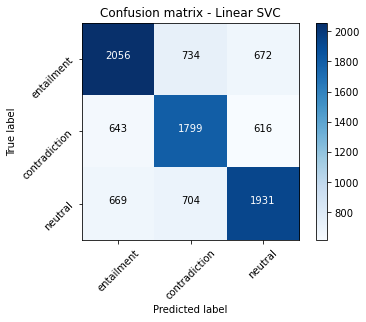

In [79]:
visualize_confusion_matrix(y_test, pred)

